## Importy

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Nacitanie dat + Predspracovanie

In [25]:
# Načítanie datasetu z CSV súboru do pandas DataFrame
df = pd.read_csv('sales_data.csv')

# Definícia OrdinalEncoder s explicitným poradím pre kategórie v stĺpci 'Age_Group',
# kde vekové skupiny majú prirodzené poradie od najmladších po najstarších.
ordinal_encoder = OrdinalEncoder(categories=[['Youth (<25)', 'Young Adults (25-34)', 'Adults (35-64)', 'Seniors (64+)']])

# Transformácia stĺpca 'Age_Group' pomocou OrdinalEncoder,
# kde každá veková skupina bude nahradená číselnou hodnotou na základe definovaného poradia.
df['Age_Group_Encoded'] = ordinal_encoder.fit_transform(df[['Age_Group']])

# Inicializácia LabelEncoder na zakódovanie kategórií ako číselných hodnôt.
label_encoder = LabelEncoder()

# Transformácia stĺpca 'Customer_Gender' pomocou LabelEncoder,
# kde každé pohlavie bude zakódované číselnou hodnotou (napr. 0 pre 'Female', 1 pre 'Male').
df['Customer_Gender_Encoded'] = label_encoder.fit_transform(df['Customer_Gender'])

# Transformácia stĺpca 'Country' pomocou LabelEncoder,
# kde každá krajina bude nahradená číselnou hodnotou na základe poradia krajín v datasete.
df['Country_Encoded'] = label_encoder.fit_transform(df['Country'])

# Transformácia stĺpca 'State' pomocou LabelEncoder,
# kde každý štát bude nahradený číselnou hodnotou na základe poradia štátov v datasete.
df['State_Encoded'] = label_encoder.fit_transform(df['State'])

# Transformácia stĺpca 'Product_Category' pomocou LabelEncoder,
# kde každá kategória produktu bude nahradená číselnou hodnotou.
df['Product_Category_Encoded'] = label_encoder.fit_transform(df['Product_Category'])

# Vytvorenie vstupných atribútov X, ktoré obsahujú číselne zakódované hodnoty
# pre rôzne charakteristiky zákazníka a obchodné dáta, ako napríklad vek, pohlavie, krajina, štát, produktová kategória, množstvo objednávok, zisk a tržby.
X = df[['Customer_Age', 'Customer_Gender_Encoded', 'Country_Encoded', 'State_Encoded', 'Product_Category_Encoded', 'Order_Quantity', 'Profit', 'Revenue']]

# Vytvorenie výstupných hodnôt y, ktoré predstavujú zakódovanú vekovú skupinu zákazníka.
y = df['Age_Group_Encoded'].values


## Rozdelenie dat na trenovacie a testovacie

In [26]:
# Rozdelenie dát na tréningovú a testovaciu množinu.
# X (vstupy) a y (cieľové hodnoty) sú rozdelené v pomere 80% na tréning a 20% na testovanie.
# random_state=42 zaisťuje, že rozdelenie bude vždy rovnaké, aby sa zachovala reprodukovateľnosť.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalizacia dat

In [27]:
# Inicializácia StandardScaler, ktorý bude používaný na škálovanie údajov.
# StandardScaler transformuje údaje tak, že každá črta bude mať priemer 0 a smerodajnú odchýlku 1.
scaler = StandardScaler()

# Škálovanie tréningovej množiny pomocou fit_transform, kde scaler najskôr vypočíta
# priemer a odchýlku na základe tréningových dát a následne tieto dáta transformuje.
X_train_scaled = scaler.fit_transform(X_train)

# Škálovanie testovacej množiny pomocou transform, kde sa použijú rovnaké parametre
# (priemer a smerodajná odchýlka) získané z tréningových dát, aby testovacie dáta boli transformované rovnako.
X_test_scaled = scaler.transform(X_test)

## Dataset + Dataloader

In [29]:
# Definícia vlastného datasetu pre vekové skupiny, ktorý dedí od torch.utils.data.Dataset.
class AgeGroupDataset(Dataset):
    def __init__(self, X_features, y_labels):
        # Konverzia vstupných a cieľových dát na tensorové objekty pytorch s príslušným dátovým typom.
        # X_features sa konvertuje na float32, y_labels na long (pre klasifikačné úlohy).
        self.X_features = torch.tensor(X_features, dtype=torch.float32)
        self.y_labels = torch.tensor(y_labels, dtype=torch.long)  # Dátový typ long pre triedenie

    def __len__(self):
        # Vráti počet vzoriek v datasete.
        return len(self.X_features)

    def __getitem__(self, idx):
        # Vráti vstupné a cieľové hodnoty pre daný index idx.
        return self.X_features[idx], self.y_labels[idx]

# Vytvorenie inštancií vlastného datasetu pre tréning a testovanie.
train_dataset = AgeGroupDataset(X_train_scaled, y_train)
test_dataset = AgeGroupDataset(X_test_scaled, y_test)

# Vytvorenie DataLoader pre tréningový dataset s dávkami veľkosti 768 a s náhodným zmiešaním vzoriek.
train_loader = DataLoader(train_dataset, batch_size=768, shuffle=True)

# Vytvorenie DataLoader pre testovací dataset s dávkami veľkosti 768 a bez náhodného zmiešania vzoriek.
test_loader = DataLoader(test_dataset, batch_size=768, shuffle=False)

# Iterácia cez dávky v tréningovom DataLoaderi a výpis rozmerov vstupov a cieľových hodnôt.
# for inputs, targets in train_loader:
#     print("Inputs:", inputs.shape)  # Rozmer tensoru vstupov
#     print("Targets:", targets.shape)  # Rozmer tensoru cieľových hodnôt
#     break  # Skončí po prvom cykle pre výpis rozmerov

## Neuronova siet

In [6]:
class AgeGroupNN(nn.Module):
    def __init__(self, in_features=8, hl1=32, hl2=16, out_features=4):
        # Inicializácia základného triedy nn.Module
        super(AgeGroupNN, self).__init__()
        # Architektúra zostáva nezmenená
        # self.fc1 = nn.Linear(8, 128)
        # self.bn1 = nn.BatchNorm1d(128)
        # self.dropout1 = nn.Dropout(0.1)
        
        # self.fc2 = nn.Linear(8, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        # self.dropout2 = nn.Dropout(0.3)

        # Definícia vrstiev neurónovej siete:
        # Prvá skrytá vrstva: lineárna vrstva so vstupnými atribútmi 'in_features' a výstupom 'hl1'
        self.fc3 = nn.Linear(in_features, hl1)
        # Batch Normalization pre skrytú vrstvu 'hl1', normalizuje výstupy z fc3
        self.bn3 = nn.BatchNorm1d(hl1)
        # Dropout pre reguláciu overfittingu (je zakomentovaný)
        # self.dropout3 = nn.Dropout(0.2)

        # Druhá skrytá vrstva: lineárna vrstva s 'hl1' vstupmi a 'hl2' výstupmi
        self.fc4 = nn.Linear(hl1, hl2)
        # Batch Normalization pre skrytú vrstvu 'hl2', normalizuje výstupy z fc4
        self.bn4 = nn.BatchNorm1d(hl2)
        # Dropout pre reguláciu overfittingu
        self.dropout4 = nn.Dropout(0.2)

        # Výstupná vrstva: lineárna vrstva s 'hl2' vstupmi a 'out_features' výstupmi
        # 'out_features' predstavuje počet tried vo výstupnej kategórii (4 vekové skupiny)
        self.fc5 = nn.Linear(hl2, out_features)

    def forward(self, x):
        # Predný prechod (forward pass) cez sieť:
        # x = torch.relu(self.bn1(self.fc1(x)))  # (zakomentované) aplikácia ReLU a batch normalization
        # x = self.dropout1(x)  # (zakomentované) aplikácia dropout

        # Aplikácia ReLU aktivačnej funkcie a batch normalization pre 'fc3'
        x = torch.relu(self.bn3(self.fc3(x)))
        # x = self.dropout3(x)  # (zakomentované) aplikácia dropout

        # Aplikácia ReLU aktivačnej funkcie a batch normalization pre 'fc4'
        x = torch.relu(self.bn4(self.fc4(x)))
        # Aplikácia dropout pre 'fc4'
        x = self.dropout4(x)

        # Výstup z poslednej lineárnej vrstvy
        x = self.fc5(x)
        
        return x
        
# Inicializácia modelu s preddefinovanými parametrami
model = AgeGroupNN()

# Inicializácia optimalizátora Adam s learning rate 0.0003
# weight_decay pridáva L2 regularizáciu, ktorá penalizuje veľké váhy pre zlepšenie generalizácie modelu
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

# Inicializácia stratovej funkcie CrossEntropyLoss pre viactriednu klasifikáciu
# Toto bude počítať stratový výstup medzi predikciami modelu a skutočnými triedami
criterion = nn.CrossEntropyLoss()

## Trenovanie modelu

In [35]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        # Inicializácia parametrov early stoppingu:
        # patience - počet epoch bez zlepšenia, po ktorých sa zastaví tréning
        # min_delta - minimálny rozdiel, ktorý je považovaný za zlepšenie
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0  # Čítač epoch bez zlepšenia
        self.best_loss = None  # Najlepšia (najnižšia) strata dosiahnutá doteraz
        self.early_stop = False  # Flag, ktorý určuje, či sa má tréning zastaviť

    def __call__(self, val_loss):
        # Metóda sa volá po každej epoche s aktuálnou validačnou stratou
        if self.best_loss is None:
            # Nastavenie prvej hodnoty strata ako najlepšej straty
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            # Ak sa strata zlepšila viac než min_delta, aktualizuje najlepšiu stratu a resetuje čítač
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Ak sa strata nezlepšila, zvýši čítač
            self.counter += 1
            # Ak čítač dosiahne hodnotu patience, aktivuje early stopping
            if self.counter >= self.patience:
                self.early_stop = True


def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    criterion, 
    optimizer, 
    num_epochs = 100,
    patience: int = 10,
    device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
    # Inicializácia tréningového procesu
    torch.manual_seed(42)  # Nastavenie náhodného semena pre reprodukovateľnosť
    model.to(device)  # Presunutie modelu na zvolený device (CPU alebo GPU)

    train_losses, train_accuracies = [], []  # Sklady pre tréningové straty a presnosti
    val_losses, val_accuracies = [], []  # Sklady pre validačné straty a presnosti

    # Inicializácia early stoppingu
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(num_epochs):
        # Trenovacia fáza
        model.train()  # Nastavenie modelu do tréningového režimu
        train_loss, correct, total = 0, 0, 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Presunutie dát na device
            optimizer.zero_grad()  # Nulovanie gradientov pred spätným prechodom
            
            outputs = model(inputs)  # Predikcie modelu
            loss = criterion(outputs, targets)  # Výpočet straty
            
            loss.backward()  # Výpočet gradientov
            optimizer.step()  # Aktualizácia váh

            train_loss += loss.item()  # Akumulácia straty
            _, predicted = outputs.max(1)  # Získanie predikcií modelu
            total += targets.size(0)  # Akumulácia celkového počtu vzoriek
            correct += predicted.eq(targets).sum().item()  # Počet správne klasifikovaných vzoriek
        
        train_loss /= len(train_loader)  # Priemerná strata
        train_accuracy = 100. * correct / total  # Presnosť
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validácia fáza
        model.eval()  # Nastavenie modelu do evaluačného režimu
        val_loss, correct, total = 0, 0, 0

        with torch.inference_mode():  # Deaktivácia gradientov pre inferenciu
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Presunutie dát na device

                outputs = model(inputs)  # Predikcie modelu
                loss = criterion(outputs, targets)  # Výpočet straty

                val_loss += loss.item()  # Akumulácia validačnej straty
                _, predicted = outputs.max(1)  # Získanie predikcií modelu
                total += targets.size(0)  # Akumulácia celkového počtu vzoriek
                correct += predicted.eq(targets).sum().item()  # Počet správne klasifikovaných vzoriek

        val_loss /= len(test_loader)  # Priemerná validačná strata
        val_accuracy = 100. * correct / total  # Validácia presnosť
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Výpis výsledkov pre aktuálnu epochu
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, | "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Kontrola early stoppingu
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping activated.")
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    return train_losses, train_accuracies, val_losses, val_accuracies

# Trénovanie a validácia modelu
train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, patience=10
)

Epoch 1/100, Train Loss: 0.0421, Train Accuracy: 98.46%, | Validation Loss: 0.0082, Validation Accuracy: 99.94%
Epoch 2/100, Train Loss: 0.0332, Train Accuracy: 98.86%, | Validation Loss: 0.0127, Validation Accuracy: 99.77%
Epoch 3/100, Train Loss: 0.0411, Train Accuracy: 98.36%, | Validation Loss: 0.0100, Validation Accuracy: 99.80%
Epoch 4/100, Train Loss: 0.0350, Train Accuracy: 98.64%, | Validation Loss: 0.0083, Validation Accuracy: 99.81%
Epoch 5/100, Train Loss: 0.0365, Train Accuracy: 98.52%, | Validation Loss: 0.0083, Validation Accuracy: 99.89%
Epoch 6/100, Train Loss: 0.0475, Train Accuracy: 98.08%, | Validation Loss: 0.0099, Validation Accuracy: 99.92%
Epoch 7/100, Train Loss: 0.0378, Train Accuracy: 98.69%, | Validation Loss: 0.0093, Validation Accuracy: 99.92%
Epoch 8/100, Train Loss: 0.0369, Train Accuracy: 98.68%, | Validation Loss: 0.0086, Validation Accuracy: 99.93%
Epoch 9/100, Train Loss: 0.0371, Train Accuracy: 98.54%, | Validation Loss: 0.0095, Validation Accuracy:

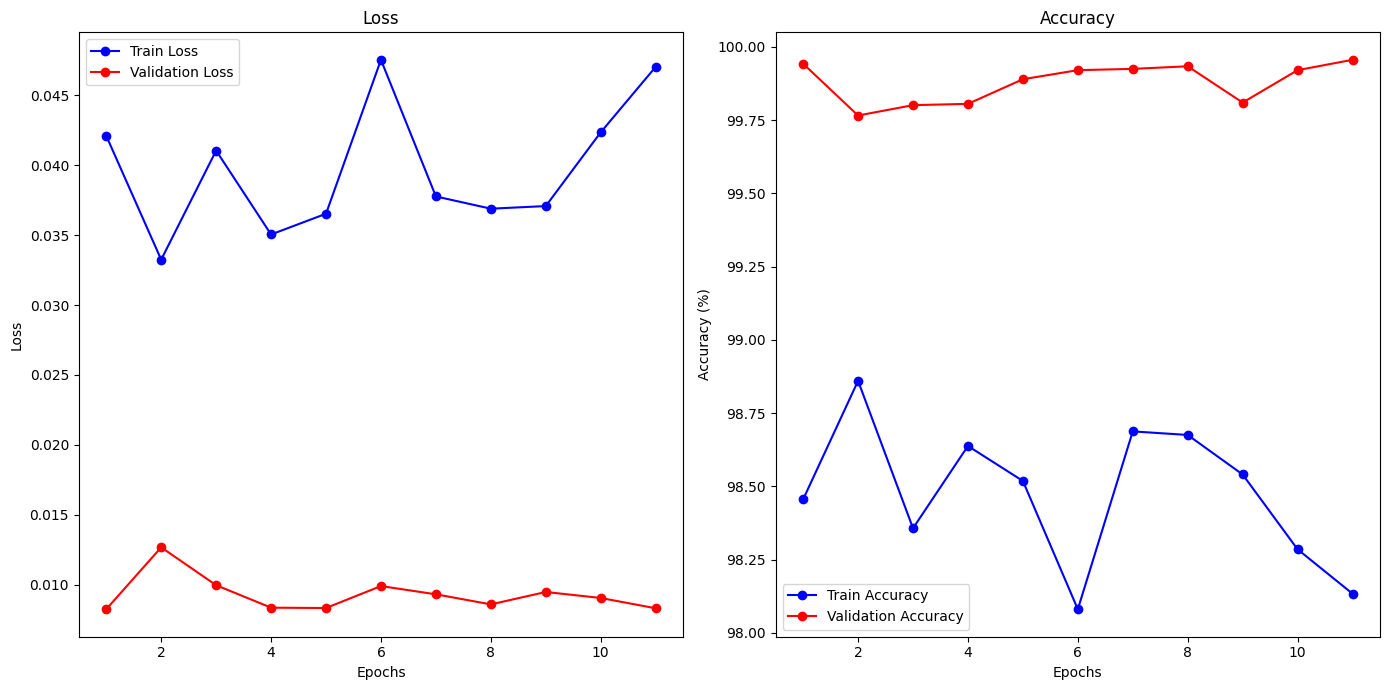

In [36]:
from helper_functions import plot_predictions, plot_decision_boundary  # Import funkcií na vizualizáciu predikcií a rozhodovacích hraníc

# Funkcia na plotovanie výsledkov tréningu a validácie
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)  # Vytvorenie rozsahu epoch pre x-ovú os

    plt.figure(figsize=(14, 7))  # Vytvorenie nového plátna pre grafy s veľkosťou 14x7 palcov
    
    # Graf pre tréningovú a validačnú stratu
    plt.subplot(1, 2, 1)  # Vytvorenie prvej podgrafiky (1 riadok, 2 stĺpce, prvý graf)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')  # Plotovanie tréningovej straty (modrá, kruhové značky)
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')  # Plotovanie validačnej straty (červená, kruhové značky)
    plt.title('Loss')  # Titulok grafu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Loss')  # Popis y-ovej osi
    plt.legend()  # Zobrazenie legendy grafu

    # Graf pre tréningovú a validačnú presnosť
    plt.subplot(1, 2, 2)  # Vytvorenie druhej podgrafiky (1 riadok, 2 stĺpce, druhý graf)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')  # Plotovanie tréningovej presnosti (modrá, kruhové značky)
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')  # Plotovanie validačnej presnosti (červená, kruhové značky)
    plt.title('Accuracy')  # Titulok grafu
    plt.xlabel('Epochs')  # Popis x-ovej osi
    plt.ylabel('Accuracy (%)')  # Popis y-ovej osi
    plt.legend()  # Zobrazenie legendy grafu

    plt.tight_layout()  # Automatické prispôsobenie rozloženia grafov
    plt.show()  # Zobrazenie grafov

# Volanie funkcie na plotovanie výsledkov s predtým vypočítanými hodnotami
plot_results(train_losses, train_accuracies, val_losses, val_accuracies)

In [37]:
def predict_age_group(model, input_data, scaler, ordinal_encoder):
    # Skontrolujte, či input_data je DataFrame s požadovanými názvami stĺpcov
    if not isinstance(input_data, pd.DataFrame):
        raise ValueError("input_data must be a pandas DataFrame")
    
    # Definujte očakávané názvy stĺpcov
    expected_columns = ['Customer_Age', 'Customer_Gender_Encoded', 'Country_Encoded', 
                        'State_Encoded', 'Product_Category_Encoded', 'Order_Quantity', 
                        'Profit', 'Revenue']
    
    # Skontrolujte, či všetky očakávané stĺpce sú prítomné v input_data
    if not all(col in input_data.columns for col in expected_columns):
        raise ValueError(f"input_data must contain all of these columns: {expected_columns}")
    
    # Uistite sa, že vstupné dáta majú rovnaké stĺpce ako tréningové dáta
    input_data = input_data[expected_columns]
    
    # Transformujte vstupné dáta pomocou škálovača
    input_scaled = scaler.transform(input_data)
    
    # Preveďte na tensor
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    
    # Predikcia
    model.eval()  # Nastavenie modelu do evaluačného režimu
    with torch.no_grad():  # Deaktivácia gradientov počas inferencie
        output = model(input_tensor)
    
    # Získanie predikovaných tried
    _, predicted = torch.max(output, 1)
    
    # Dekódovanie predikovaných tried
    decoded_predictions = ordinal_encoder.inverse_transform(predicted.numpy().reshape(-1, 1))
    
    return decoded_predictions.flatten()

def generate_input_data():
    # Vytvorenie náhodného DataFrame pre vstupné dáta
    input_data = pd.DataFrame({
        'Customer_Age': np.random.randint(18, 80, 5),  # Náhodný vek medzi 18 a 80
        'Customer_Gender_Encoded': np.random.randint(0, 2, 5),  # Náhodné kódovanie pohlavia (0 alebo 1)
        'Country_Encoded': np.random.randint(0, 10, 5),  # Náhodné kódovanie krajiny (0 až 9)
        'State_Encoded': np.random.randint(0, 50, 5),  # Náhodné kódovanie štátu (0 až 49)
        'Product_Category_Encoded': np.random.randint(0, 5, 5),  # Náhodné kódovanie produktovej kategórie (0 až 4)
        'Order_Quantity': np.random.randint(1, 20, 5),  # Náhodné množstvo objednávok medzi 1 a 20
        'Profit': np.random.uniform(10, 1000, 5),  # Náhodný zisk medzi 10 a 1000
        'Revenue': np.random.uniform(100, 5000, 5)  # Náhodný príjem medzi 100 a 5000
    })
    return input_data

# Predpokladajme, že model, škálovač a ordinal_encoder sú už natrénované alebo načítané
# Ak nie, je potrebné ich natrénovať alebo načítať tu

# Generovanie vstupných dát
input_data = generate_input_data()

# Urobte predikcie
try:
    predictions = predict_age_group(model, input_data, scaler, ordinal_encoder)

    # Zobrazenie výsledkov
    print("Input data:")
    print(input_data)
    print("\nPredicted age groups:")
    for i, pred in enumerate(predictions):
        print(f"Sample {i+1}: {pred}")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Input data:
   Customer_Age  Customer_Gender_Encoded  Country_Encoded  State_Encoded  \
0            40                        1                7              1   
1            50                        0                7             26   
2            20                        1                1             41   
3            35                        1                5              1   
4            42                        0                6             25   

   Product_Category_Encoded  Order_Quantity      Profit      Revenue  
0                         0              10  506.501132  4461.026175  
1                         0               3  800.312227  1756.176269  
2                         0              18  653.464291  1940.356468  
3                         2              13  704.947208   560.511505  
4                         4               7  797.834743  2933.572691  

Predicted age groups:
Sample 1: Adults (35-64)
Sample 2: Adults (35-64)
Sample 3: Youth (<25)
Sample 4: 